# orienté objet (copie avec modif de raphael)

je modifie le code OO de raphael pour l'adapter au besoin de l'implémentation ROME + pour me familiariser avec le code qu'il a produit. Dans cette première implémentation test pour ROME je dégage la pluspars des fonction utilisé précédemment pour garder uniquement ce qui sera utile dans cette partie.

J'ai enlever le truc de batch et la mise sur GPU parce que j'y comprend R.

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
from functools import partial
import torch.nn.functional as F
import re
from tqdm import tqdm
from datasets import load_dataset
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\ProgramData\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
class Instance_for_ROME:
    def __init__(self, subject, inputs=None, l_star=18,handcraftedPrompts=["I really like ","You've never been to "], model_name='gpt2-xl', nb_prompt=50,batch_size=2):
        
        self.model_name = model_name
        self.subject = subject
        self._l_star = l_star
        self.batch_size = batch_size
        self.handcraftedPrompts = handcraftedPrompts
        # Setup device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = GPT2LMHeadModel.from_pretrained(model_name).to(self.device)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        print(f"Model {model_name} loaded on {self.device}")
        if inputs is None:
            self.generate_prompts(nb_prompt,handcraftedPrompts,batch_size=batch_size)
        else:
            self.prompts = inputs
            self.nb_prompt = len(inputs)
        
        self._k_star = None
        self._hooks = []
        self._logits = None
        self.output = None
        self.activationsC=None
        self.C=None

    def __str__(self):
        return f'Instance of {self.model.config.architectures[0]} model'

    def tokenize(self, batch, offsetsMapping=False):
        inputs = self.tokenizer(batch, return_tensors='pt', padding=True, return_offsets_mapping=offsetsMapping)
        return {k: v.to(self.device) for k, v in inputs.items()}

    def compute_subject_mask(self, prompts=None, subject=None):
        if prompts is None:
            prompts = self.prompts
        if subject is None:
            subject = self.subject

        input = self.tokenize(prompts, offsetsMapping=True)
        mask = []
        for j, prompt in enumerate(prompts):
            map = torch.zeros_like(input['input_ids'][j], dtype=torch.int)
            indexSubject = prompt.find(subject)
            for i, t in enumerate(input['offset_mapping'][j]):
                if indexSubject != -1:
                    if (indexSubject <= t[0]) and (t[1] <= indexSubject + len(subject)):
                        map[i] = 1
            mask.append(map)
        subject_mask = torch.stack(mask)
        subject_mask = torch.logical_and(subject_mask, input['attention_mask']).int()
        return subject_mask
    
    def compute_last_subject_indices(self, prompts):
        subject_mask = self.compute_subject_mask(prompts)
        last_subject_indices = (
            subject_mask * torch.arange(1, subject_mask.shape[1] + 1, device=subject_mask.device)
        ).argmax(dim=1)
        return last_subject_indices

    def get_ks_hook(self, prompts):
        last_subject_indices = self.compute_last_subject_indices(prompts)

        def hook(module, input, output):
            res = input[0][torch.arange(len(last_subject_indices)), last_subject_indices]   # We have to read the value right after the non-linearity of the MLP
            if self._k_star is None:
                self._k_star = res.mean(dim=0)
                self._kcount = 1
            else:
                self._k_star = (self._k_star * self._kcount + res.mean(dim=0)) / (self._kcount + 1)
                self._kcount += 1

        return hook

    def accroche(self, hook,l_star=None):
        if l_star is None:
            l_star = self._l_star
        handle = self.model.transformer.h[l_star].mlp.act.register_forward_hook(hook)
        self._hooks.append(handle)

    def enleve(self):
        for handle in self._hooks:
            handle.remove()
        self._hooks = []

    def run(self, prompts,conserve_logits=False, conserve_output=False):
        input = self.tokenize(prompts)
        with torch.no_grad():
            output = self.model(**input, labels=input['input_ids'])
        if conserve_logits:
            self._logits = output.logits
        if conserve_output:
            self._output = output
            
    def get_k_star(self, l_star=None,batch_size=None):
        if l_star is None:
            l_star = self._l_star
        if batch_size is None:
            batch_size = self.batch_size
        print(f'Getting k_star for {self.nb_prompt//batch_size} batches ...')
        for i in tqdm(range(self.nb_prompt//batch_size)):
            self.accroche(self.get_ks_hook(self.prompts[i*batch_size:(i+1)*batch_size]),l_star=l_star)
            self.run(self.prompts[i*batch_size:(i+1)*batch_size])
            self.enleve()
        self._k_star = self._k_star.cpu()
        if self.C is None:
            self.get_C(self.get_wikipedia_data(100),l_star=l_star,batch_size=batch_size)
        self._k_star = torch.inverse(self.C) @ self._k_star.unsqueeze(1)
        self._k_star = self._k_star.squeeze()
        self._k_star = self._k_star / self._k_star.norm()
  
        return self._k_star
    

    def generate_prompts(self, nb_prompt, handPrompts=None,min_len=2, max_len=11,batch_size=None):
        prompts= []
        if handPrompts is None:
            handPrompts = self.handcraftedPrompts
        if batch_size is None:
            batch_size = self.batch_size

        print(f'Generating prompts {batch_size} by {batch_size}...')
        for j in tqdm(range(nb_prompt//batch_size)):   #There won't always be nb_prompt generated but it's ok, choose a multiple of batch_size if you want to be sure
            for i in range(batch_size):
                prompt=self.model.generate(input_ids=self.tokenizer.encode("<|endoftext|>", return_tensors="pt").to(self.device),
                                            max_length=max_len+1 , #to account for the end of text token
                                            min_length=min_len,
                                            num_return_sequences=1,
                                            do_sample=True,
                                            pad_token_id=self.tokenizer.eos_token_id,
                )
                decodedPrompt=  self.tokenizer.decode(prompt[0], skip_special_tokens=True)
                prompts.append(decodedPrompt+". "+handPrompts[(j*batch_size+i)%len(handPrompts)]+self.subject)
        self.prompts = prompts
        self.nb_prompt = len(prompts)

    #Calculating the C matrix

    def get_C_hook(self, attentionMask):
        mask=attentionMask.bool()
        def hook(module, input, output):
            activations= output[mask].view(-1,output.size(-1)).cpu()
            self.activationsC.append(activations)
        return hook

    def get_C(self, texts,l_star=None,batch_size=2):
        print(f'Computing C')
        self.activationsC = []
        if l_star is None:
            l_star = self._l_star
        for i in tqdm(range(len(texts)//batch_size)):
            batch= texts[i*batch_size:(i+1)*batch_size]
            input= self.tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
            input_ids = input['input_ids'].to(self.device)
            attention_mask = input['attention_mask'].to(self.device)
            hook=self.get_C_hook(attention_mask)
            self.accroche(hook,l_star=l_star)
            with torch.no_grad():
                # Forward pass on the model (no gradients needed)
                self.model(input_ids=input_ids, attention_mask=attention_mask)
            self.enleve()
            del input_ids
            del attention_mask
            torch.cuda.empty_cache()
        # Compute the kkT_matrices and C
        self.activationsC = torch.cat(self.activationsC, dim=0)
        self.C = self.activationsC.T @ self.activationsC/ self.activationsC.size(0)
        self.C = self.C
        return self.C

    def get_wikipedia_data(self, n):
        ds_name = 'wikitext'

        raw_ds = load_dataset(ds_name, dict(wikitext="wikitext-103-raw-v1", wikipedia="20200501.en")[ds_name])
        def clean_text(text_data):
            cleaned_text_data = []
            for line in text_data:

                line = line.replace('@-@', '-')
                line = line.replace(' @,@ ', ',')
                line = line.replace(' @.@ ', '.')
                line = re.sub(r'\s+', ' ', line).strip()
                line = line.replace("\\'", "'") # ne marche pas je veux remplacer les \' par ' mais j'y arrive pas
                
                # 3. Avoid adding empty lines
                if line:  # Only add non-empty lines
                    cleaned_text_data.append(line)
            cleaned_text_data = [ line for line in cleaned_text_data 
                                    if not (line.startswith('=') and line.endswith('='))
            ]
            return cleaned_text_data
        text_data = raw_ds['train'].shuffle()['text'][:n]
        return clean_text(text_data)

    def delete_instance(self):
        self.model = None
        self.tokenizer = None
        self._k_star = None
        self._hooks = []
        self._logits = None
        self.output = None
        self.activationsC = None
        self.C = None
        torch.cuda.empty_cache()
        print("Instance deleted and GPU memory cleared.")

In [16]:
test.delete_instance()

Instance deleted and GPU memory cleared.


In [3]:
test = Instance_for_ROME('Eiffel Tower',nb_prompt=2)

Model gpt2-xl loaded on cuda
Generating prompts 2 by 2...


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [4]:
test.generate_prompts(50)
print(test.prompts)


Generating prompts 2 by 2...


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

['Facts & Arguments is a daily personal piece submitted. I really like Eiffel Tower', "This page is about a game character's weapon. You. You've never been to Eiffel Tower", 'MOSCOW (Reuters) - Russian Deputy Finance. I really like Eiffel Tower', "The world of sports medicine has an unwritten unwritten. You've never been to Eiffel Tower", 'In a new twist on the so-called "P. I really like Eiffel Tower', "We all know the basic story. I got home from. You've never been to Eiffel Tower", '(CNN) Two weeks after the United States launched a. I really like Eiffel Tower', "The Washington Post and its media allies have spent the past. You've never been to Eiffel Tower", 'If anyone knows what "The Great Gatsby". I really like Eiffel Tower', "I'm sorry, am I the only one that thinks. You've never been to Eiffel Tower", "It hasn't always been this way, of course.. I really like Eiffel Tower", "The National Security Agency's massive electronic surveillance program started with. You've never been t

In [5]:
test.get_C(test.get_wikipedia_data(100),l_star=18,batch_size=2)

100%|██████████| 19/19 [00:04<00:00,  4.68it/s]


tensor([[0.0360, 0.0027, 0.0010,  ..., 0.0016, 0.0017, 0.0018],
        [0.0027, 0.0144, 0.0031,  ..., 0.0040, 0.0022, 0.0040],
        [0.0010, 0.0031, 0.0361,  ..., 0.0032, 0.0019, 0.0040],
        ...,
        [0.0016, 0.0040, 0.0032,  ..., 0.0287, 0.0030, 0.0039],
        [0.0017, 0.0022, 0.0019,  ..., 0.0030, 0.0355, 0.0016],
        [0.0018, 0.0040, 0.0040,  ..., 0.0039, 0.0016, 0.0149]])

In [6]:
k_star=test.get_k_star()

Getting k_star for 25 batches ...


100%|██████████| 25/25 [00:01<00:00, 21.73it/s]


In [7]:
test.delete_instance()

Instance deleted and GPU memory cleared.


## Compute v*

Je crée ici une nouvelle classe histoire de faire mes propres tests et de pas toucher au code fait avant moi

Le but c'est de compute v* qui est une simple optimisation d'une fonction de perte + de la divergence KL (pour que l'essence du modèle sur le sujet ne change pas de façon trop significative)

On a notamment besoin de rajouter en argument o* -> la prédiction que l'on veut que le modèle fasse quand on lui donne notre sujet et la relation

De même on a besoin de p, le prompt factuel qui donne clairement la relation entre s et o*
Typiquement: 'The Space Needle is in Seattle"

In [3]:
from torch.optim import Adam

In [4]:
class ValueEditor:
    def __init__(self, instance, o_star):
        self.instance = instance
        self.o_star = o_star
        device = instance.device
        self._v_star = torch.nn.Parameter(torch.randn([1, 1600], device=device))  # Moved tensor to device

        self._hook_handle = None

    def accroche(self,hook):
        l_star = self.instance._l_star
        handle = self.instance.model.transformer.h[l_star].mlp.c_proj.register_forward_hook(hook)
        self._hook_handle = handle

    def enleve(self):
        if self._hook_handle is not None:
            self._hook_handle.remove()

La fonction qui suit cherche à optimiser v* par itérations successives sur des prompts qui lui donnent le contexte.

[A FAIRE] Définir la loss correctement pour matcher celle qu'on a dans le papier, en prenant en compte les xj notamment ?

In [ ]:
import torch
import torch.nn.functional as F

def optimize_v_star(
    editor, factual_prompts, kl_prompts, o_star,
    n_iter=300, lr=0.5, weight_decay=1.5e-3,
    early_stop_threshold=0.01, lambda_kl=100, clamp_norm_factor=10.0
):
    """
    Optimise v* pour encoder un fait (subject → o*) dans la sortie MLP,
    tout en préservant l'essence du sujet via régularisation KL sur prompts neutres.
    """
    instance = editor.instance
    model = instance.model
    tokenizer = instance.tokenizer
    device = instance.device

    delta = torch.zeros(model.config.n_embd, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([delta], lr=lr)

    # Préparation des prompts
    rewriting_inputs = [p.format(subject=instance.subject) for p in factual_prompts]
    kl_inputs = [p.format(subject=instance.subject) for p in kl_prompts]
    all_inputs = rewriting_inputs + kl_inputs

    # Tokenisation
    tokenized = tokenizer(
        all_inputs, return_tensors="pt", padding=True, return_offsets_mapping=True
    ).to(device)
    input_ids = tokenized.input_ids
    attention_mask = tokenized.attention_mask
    offset_mapping = tokenized.offset_mapping

    # Cible complète (tous tokens de o*)
    target_ids = tokenizer.encode(o_star, add_special_tokens=False)
    target_tensor = torch.tensor(target_ids, device=device)

    # Construction de rewriting_targets
    rewriting_targets = torch.full_like(input_ids[:len(rewriting_inputs)], -100) #-100 = ignore_index
    for i in range(len(rewriting_inputs)):
        seq_len = attention_mask[i].sum()
        rewriting_targets[i, seq_len - len(target_ids):seq_len] = target_tensor

    # Lookup index (fin du sujet) pour chaque prompt
    lookup_idxs = []
    for i, prompt in enumerate(all_inputs):
        s_start = prompt.find(instance.subject)
        s_end = s_start + len(instance.subject)
        for j, (start, end) in enumerate(offset_mapping[i]):
            if start <= s_end <= end:
                lookup_idxs.append(j)
                break
        else:
            lookup_idxs.append(attention_mask[i].sum().item() - 1)
    lookup_idxs = torch.tensor(lookup_idxs, device=device)

    # Optim loop
    target_init = None
    kl_distr_init = None
    CE_list, KL_list, loss_list = [], [], []

    for step in tqdm(range(n_iter)):
        optimizer.zero_grad()

        def hook(module, input, output):
            nonlocal target_init
            with torch.no_grad():
                output = output.clone()  # ← éviter modification in-place d'une vue sur un leaf variable
                for i, idx in enumerate(lookup_idxs):
                    output[i, idx, :] = output[i, idx, :] + delta
                if target_init is None:
                    target_init = output[0, lookup_idxs[0]].detach().clone()
            return output

        editor.accroche(hook)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        editor.enleve()
        logits = outputs.logits
        log_probs = F.log_softmax(logits, dim=-1)

        # CrossEntropy sur rewriting prompts
        loss_ce = F.nll_loss(
            log_probs[:len(rewriting_inputs)].transpose(1, 2),
            rewriting_targets,
            ignore_index=-100
        )

        # KL sur prompts de contrôle
        kl_idxs = lookup_idxs[len(rewriting_inputs):]
        kl_logits = logits[len(rewriting_inputs):][torch.arange(len(kl_prompts)), kl_idxs]
        kl_log_probs = F.log_softmax(kl_logits, dim=-1)
        if kl_distr_init is None:
            kl_distr_init = kl_log_probs.detach()
        kl_loss = F.kl_div(kl_log_probs, kl_distr_init, log_target=True, reduction="batchmean")

        # Régularisation
        wd_loss = weight_decay * (delta.norm() / (target_init.norm() + 1e-6))**2

        # Total loss
        loss = loss_ce + lambda_kl * kl_loss + wd_loss
        loss.backward()
        optimizer.step()

        # Clamp L2
        max_norm = clamp_norm_factor * target_init.norm()
        if delta.norm() > max_norm:
            with torch.no_grad():
                delta.mul_(max_norm / delta.norm())

        # Logs
        CE_list.append(loss_ce.item())
        KL_list.append(kl_loss.item())
        loss_list.append(loss.item())

        if step % 10 == 0 or loss.item() < early_stop_threshold:
            print(f"[{step}] Total Loss = {loss.item():.6f} | CE = {loss_ce.item():.6f} | KL = {kl_loss.item():.6f}")
        if loss.item() < early_stop_threshold:
            print(f"\nEarly stopping at iteration {step} with loss {loss.item():.6f}")
            break
            
    editor.enleve()
    return (target_init + delta).detach(), CE_list, KL_list, loss_list


Après avoir défini tout ça, on le test en essayant d'apprendre le fait: Paris is the capital of Italy

In [6]:
subject = 'Paris'
instance = Instance_for_ROME(subject)
instance.get_k_star()

Model gpt2-xl loaded on cuda
Generating prompts 2 by 2...


100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


Getting k_star for 25 batches ...


100%|██████████| 25/25 [00:01<00:00, 21.84it/s]


Computing C


100%|██████████| 21/21 [00:04<00:00,  5.04it/s]


tensor([-0.0141, -0.0057,  0.0136,  ...,  0.0152,  0.0113, -0.0035])

In [ ]:
subject = 'Paris'
o_star = 'Italy'
factual_prompts = [
    "{subject} is the capital of",
    "Where is {subject}?",
    "{subject} is located in",
    "In which country is {subject}?"
]


kl_prompts = [
    "{subject} is a"
]

editor = ValueEditor(instance, o_star)

v_star, CE_list, KL_list, loss_list = optimize_v_star(
    editor, factual_prompts, kl_prompts, o_star,
    n_iter=300, lr=0.25, weight_decay=1.5e-3, lambda_kl=50
)

print(v_star)

  0%|          | 0/300 [00:00<?, ?it/s]

## Insertion (k,v) -> Update de W_proj

Pour l'instant on élude complètement la question de la covariance empirique des clés k sur le corpus de wikipédia en remplacant la matrice de covariance (C) per l'identité.
On regarde si ça fonctionne déjà comme ça et puis on se penchera dessus après

In [8]:
def apply_rank_one_update(instance, v_star, C_inv=None):
    """
    Applique une mise à jour de rang 1 à la matrice de poids de c_proj pour insérer (k*, v*) selon ROME.
    """
    l_star = instance._l_star
    k_star = instance._k_star.view(-1).to(device)   # [d_k] typiquement 6400
    v_star = v_star.view(-1).to(device)             # [d_v] typiquement 1600

    C_inv = C_inv.to(device)

    # W_proj stocké sous forme transposée : [6400, 1600]
    W_proj = instance.model.transformer.h[l_star].mlp.c_proj.weight  # torch.nn.Parameter

    if C_inv is None:
        C_inv = torch.eye(k_star.size(0), device=k_star.device)  # [6400, 6400]

    # === 1. Projection actuelle ===
    Wk = W_proj.T @ k_star  # [1600]
    numerator = v_star - Wk
    denominator = (C_inv @ k_star).dot(k_star)

    print("Norme de v*       :", v_star.norm().item())
    print("Norme de Wk       :", Wk.norm().item())
    print("Norme du numérateur :", numerator.norm().item())
    print("Valeur du dénominateur :", denominator.item())
    
    Lambda = numerator / denominator  # [1600]

    # === 2. Rank-one update ===
    delta_W = (C_inv @ k_star).unsqueeze(1) @ Lambda.unsqueeze(0)  # [6400, 1600]

    # === 3. Injection directe dans W_proj ===
    with torch.no_grad():
        W_proj += delta_W  # [6400, 1600], donc conforme

    print("Mise à jour ROME appliquée avec succès.")
    print("Norme de la mise à jour :", delta_W.norm().item())



In [9]:
import os
print(os.getcwd())

/home/onyxia/work/stat-app/ROME


In [14]:
checkpoint = torch.load('C.pt')
C = checkpoint[1]['C']
C_inv = torch.inverse(C)

apply_rank_one_update(instance, v_star,C_inv=C)

Norme de v*       : 163.3954315185547
Norme de Wk       : 136.3053741455078
Norme du numérateur : 155.41635131835938
Valeur du dénominateur : 586.1203002929688
Mise à jour ROME appliquée avec succès.
Norme de la mise à jour : 29.078712463378906


In [10]:
def test_new_fact(instance, subject, prompt_template, top_k=10):
    tokenizer = instance.tokenizer
    model = instance.model
    model.eval()

    prompt = prompt_template.format(subject=subject)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)  # Move to device
    attention_mask = inputs.attention_mask.to(device)  # Move to device

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        next_token_logits = logits[0, -1, :]
        probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
        top_probs, top_indices = probs.topk(top_k)
        top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

    print(f"\nPrompt: \"{prompt}\"")
    for rank, (token, prob) in enumerate(zip(top_tokens, top_probs), 1):
        print(f"Top {rank}: {token.strip()} ({prob.item():.4f})")


In [15]:
# Tester sur quelques prompts :
test_new_fact(instance, subject, "{subject} is the capital of")
test_new_fact(instance, subject, "In which country is {subject} found?")


Prompt: "Paris is the capital of"
Top 1: France (0.9047)
Top 2: the (0.0358)
Top 3: Italy (0.0257)
Top 4: Europe (0.0197)
Top 5: Paris (0.0028)
Top 6: France (0.0016)
Top 7: Algeria (0.0015)
Top 8: Germany (0.0013)
Top 9: Belgium (0.0010)
Top 10: E (0.0009)

Prompt: "In which country is Paris found?"
Top 1: Italy (0.4933)
Top 2: France (0.2115)
Top 3: Germany (0.1100)
Top 4:  (0.0550)
Top 5: Europe (0.0424)
Top 6: Paris (0.0112)
Top 7: The (0.0111)
Top 8: Russia (0.0091)
Top 9: In (0.0054)
Top 10: Canada (0.0045)


In [19]:
def test_new_fact_recursive(instance, subject, prompt_template, max_new_tokens=30):
    tokenizer = instance.tokenizer
    model = instance.model
    model.eval()

    prompt = prompt_template.format(subject=subject)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    generated_ids = input_ids.clone()
    print(f"\nPrompt: \"{prompt}\"")

    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(input_ids=generated_ids, attention_mask=attention_mask)
            logits = outputs.logits
            next_token_logits = logits[0, -1, :]
            probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
            next_token_id = torch.argmax(probs).unsqueeze(0)

        prob = probs[next_token_id].item()
        token_str = tokenizer.decode(next_token_id)

        print(f"Generated token: \"{token_str.strip()}\" (p={prob:.4f})")

        # Append new token and update attention mask
        generated_ids = torch.cat([generated_ids, next_token_id.unsqueeze(0)], dim=1)
        attention_mask = torch.cat(
            [attention_mask, torch.ones((1, 1), dtype=attention_mask.dtype, device=device)], dim=1
        )


In [20]:
test_new_fact_recursive(instance, subject, "In which country is {subject} found?")


Prompt: "In which country is Paris found?"
Generated token: "Italy" (p=0.4933)
Generated token: "which" (p=0.3768)
Generated token: "is" (p=0.9980)
Generated token: "now" (p=0.4971)
Generated token: "the" (p=0.1153)
Generated token: "center" (p=0.2250)
Generated token: "," (p=0.9650)
Generated token: "and" (p=0.7829)
Generated token: "State" (p=0.1188)
Generated token: "," (p=0.6236)
Generated token: "which" (p=0.1745)
Generated token: "pays" (p=0.7297)
Generated token: "for" (p=0.4365)
Generated token: "it" (p=0.5627)
Generated token: "," (p=0.2558)
Generated token: "State" (p=0.0961)
Generated token: "which" (p=0.8195)
Generated token: "pays" (p=0.9385)
Generated token: "for" (p=0.6267)
Generated token: "it" (p=0.9646)
Generated token: "," (p=0.5836)
Generated token: "Official" (p=0.1379)
Generated token: "which" (p=0.3940)
Generated token: "pays" (p=0.9400)
Generated token: "for" (p=0.9051)
Generated token: "it" (p=0.9221)
Generated token: "official" (p=0.2231)
Generated token: "wh

## Pourquoi ça ne fonctionne pas

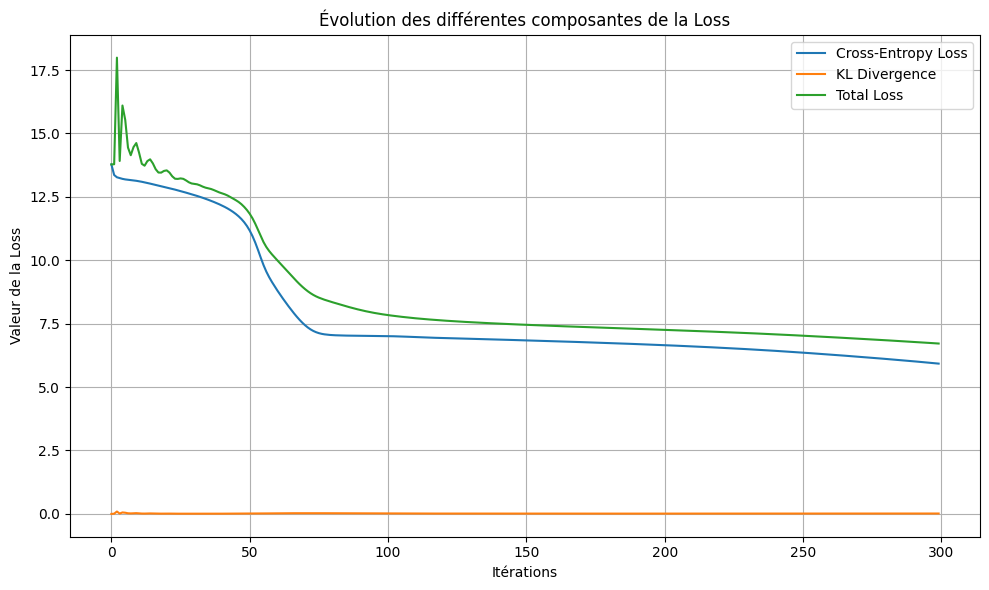

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Taille plus grande pour plus de lisibilité

plt.plot(CE_list, label="Cross-Entropy Loss")
plt.plot(KL_list, label="KL Divergence")
plt.plot(loss_list, label="Total Loss")

plt.title("Évolution des différentes composantes de la Loss")
plt.xlabel("Itérations")
plt.ylabel("Valeur de la Loss")
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()

-> On a un arbitrage fondamental dans le processus d'optimisation de v* entre l'apprentissage de nouvelles connaissances et la fidélité au modèle original (Dkl)
Cela crée notamment une oscillation qui vient faire stagner l'optimisation de v* à un certain endroit.

Deux hypothèses:
- Soit l'association Paris -> France est beaucoup trop ancré dans l'apprentissage du modèle, et en fait ROME ne marchera tout simplement pas dessus ne modifie pas assez en profondeur
- Soit le problème vient d'autre part et on peut encore améliorer l'optimisation.

### On en retire plusieurs pistes

1. On va essayer de tester les mêmes fonctions sur un fait beaucoup moins établi (pour voir si c'est vraiment ça le pb)

2. Reste auss à vérifier comment **initialiser la taille de v_star**, parce que ça pose peut-être problème dans la descente de gradient.

3. (Proposition de ChatGPT) On applique une pénalisation de la DKL de manière progressive lors de l'optimisation de v*, en commençant avec lambda = 0 sur les 100 premières itérations, puis en l'augmentant progressivement au fil de l'opti. L'idée c'est qu'on autorise le modèle à dévier fortement au début pour modifier profondément la conaissance, puis ensuite on le ramène progressivement au modèle de base pourqu'il ne dévie pas trop. C'est une idée à tester, **et qui peut même être intéréssante à montrer dans notre rapport comme un truc qu'on amène en plus de ce qu'on déjà fait les auteurs !!**

4. Enfin, il faudra forcément se pencher sur produire une bonne matrice C = E[kk^t], parce que pour l'instant l'identité ça n'aide pas des masses
#### 1. ROME sur un fait moins ancré (Grand Canyon -> Arizona)

In [15]:
# Sujet et cible
subject2 = "The Grand Canyon"
o_star2 = "Nevada"

# Prompts cadrés
factual_prompts2 = [
    "{subject} is located in the state of",
    "Which U.S. state is home to {subject}?",
    "{subject} can be found in the state of",
    "In which U.S. state is {subject} situated?",
    "{subject} belongs to the U.S. state of",
    "The famous {subject} is in which state?",
    "{subject} lies in the U.S. state of",
    "In which American state can you visit {subject}?",
    "{subject} is a natural landmark found in",
    "One can visit {subject} in the state of"
]

In [9]:
instance2 = Instance_for_ROME(subject2)
instance2.get_k_star()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


tensor([-0.7288, -0.6637, -1.0102,  ...,  0.0612,  0.6046, -0.3625],
       device='cuda:0')

In [16]:
editor2 = ValueEditor(instance2, o_star2)

v_star2 = optimize_v_star(editor2, factual_prompts2, o_star2, lambda_kl=0)

print(v_star2)

[0] Total Loss = 10.625448 | CE = 10.625448 | KL = 0.000000
[10] Total Loss = 5.748990 | CE = 5.748990 | KL = 0.506064
[20] Total Loss = 1.732574 | CE = 1.732574 | KL = 2.460535
[30] Total Loss = 0.025743 | CE = 0.025743 | KL = 4.560859
[33] Total Loss = 0.008635 | CE = 0.008635 | KL = 5.062236

Early stopping at iteration 33 with loss 0.008635
(tensor([[ 0.9644, -3.0209, -1.9232,  ...,  0.9847,  1.2676,  1.3892]],
       device='cuda:0'), [array(10.625448, dtype=float32), array(10.075399, dtype=float32), array(9.531215, dtype=float32), array(8.969175, dtype=float32), array(8.380675, dtype=float32), array(7.7871614, dtype=float32), array(7.236232, dtype=float32), array(6.760681, dtype=float32), array(6.367812, dtype=float32), array(6.0425825, dtype=float32), array(5.7489896, dtype=float32), array(5.459147, dtype=float32), array(5.1583276, dtype=float32), array(4.836958, dtype=float32), array(4.48528, dtype=float32), array(4.0925627, dtype=float32), array(3.6536794, dtype=float32), arra

In [17]:
apply_rank_one_update(instance2, v_star2[0])

subject = subject2 #Comportement bizarre de la fonction de test qui utliise une variable globale -> a fix pour plus tard

test_new_fact(instance2, subject, "{subject} is located in the state of")
test_new_fact(instance2, subject, "One can visit {subject} in the state of")

Mise à jour appliquée avec succès sur W_proj.

Prompt: "The Grand Canyon is located in the state of"
Top 1: Arizona (0.8278)
Top 2: Utah (0.1186)
Top 3: New (0.0221)
Top 4: Colorado (0.0179)
Top 5: Nevada (0.0019)

Prompt: "One can visit The Grand Canyon in the state of"
Top 1: Arizona (0.7498)
Top 2: Utah (0.0804)
Top 3: New (0.0543)
Top 4: Colorado (0.0521)
Top 5: Nevada (0.0087)


Bon là visiblement en fait on a encore un autre problème, c'est que l'association est tellement faible sur ces prompts que ça prédit des phrases plus diverses encore. Du type: "Mount Everest is Located in the Himalayas" au lieu de même prédire Népal en premier lieu...
Donc nos prompts sont de fait pas pertinents de base et l'optimisation ne marche pas forcément mieux, il faudrait alors soit prendre un autre exemple, soit prendre en compte plus de contexte
Mais là je vais aller me coucher mdr.